
# Avocado Prices

Los datos son tomados de unos de uno de los dataset que se encuentran en la plataforma Kaggle y sugeridos por el Profesor Fabio Gonzalez, el dataset con el que trabajaremos es el de Avocado prices, el cual fue descargado del sitio web [Avocado prices](https://hassavocadoboard.com/) en mayo de 2018.


Algunos campos del dataset son:

> 
- Date - La fecha de la observación
- AveragePrice - El precio promedio de un solo aguacate
- type - Tipo del aguacate si es convencional u organico
- year - el año
- Region - La ciudad o región de la observación
- Total Volume - Número total de aguacates vendidos
- 4046 - Número total de aguacates vendidos con PLU 4046
- 4225 - Número total de aguacates vendidos con PLU 4225
- 4770 - Número total de aguacates vendidos con PLU 4770


# Problema
Se desea predecir el tipo de aguacate a partir de los datos de las demás variables, es decir, predecir si el aguacate es de tipo Convencional u organico
Se utilizara un modelo **Random forest** para este problema de clasificación

# 1 Procesamiento y Exploración de Datos

Importamos las librerias y funciones que se utilizaron en el curso de Introducción a los sistemas Inteligentes de la universidad Nacional por el profesor Fabio Gonzalez y que se van a usar en el notebook


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import sklearn
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import Normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform 
from scipy.stats import randint
from sklearn.metrics import confusion_matrix
from time import time
import seaborn as sns



In [2]:
def plot_data(X, y):   #Función para graficar datos (X,y)
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):      #Función para visualizar la superficie de decisión de nuestro algoritmo.
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

def list_cm(cm,classes):     #función para generar de una forma más visual la matriz de confusión
    if len(cm)==2:
      row_0 =['','Valor','Verdadero']
      row_1 =['-',classes[0],classes[1]]
      row_2 =[classes[0],cm[0,0],cm[1,0]]
      row_3 =[classes[1],cm[0,1],cm[1,1]]
      table = zip(row_0,row_1, row_2, row_3)
      headers = ['', '', 'Valor', 'Predicho']  
      return print(tabulate(table, headers=headers, floatfmt=".4f"))
    else:
      row_0 =['','Valor','Verdadero','']
      row_1 =['-',classes[0],classes[1],classes[2]]
      row_2 =[classes[0],cm[0,0],cm[1,0],cm[2,0]]
      row_3 =[classes[1],cm[0,1],cm[1,1],cm[2,1]]
      row_4 =[classes[2],cm[0,2],cm[1,2],cm[2,2]]
      table = zip(row_0,row_1, row_2, row_3, row_4)
      headers = ['', '', 'Valor', 'Predicho', '']  
      return print(tabulate(table, headers=headers, floatfmt=".4f"))   

## 1.1 Cargue los datos

In [3]:

url = "https://drive.google.com/uc?export=download&id=1cl6kC5Z4VSsyGrrvm1w_qv2Zg5ZyBWli"

df = pd.read_csv(url)
df.dtypes

Unnamed: 0        int64
Date             object
AveragePrice    float64
Total Volume    float64
4046            float64
4225            float64
4770            float64
Total Bags      float64
Small Bags      float64
Large Bags      float64
XLarge Bags     float64
type             object
year              int64
region           object
dtype: object

In [4]:
df

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


## 1.2 Preprocesamiento de los datos
Separamos el campo fecha en columnas numéricas, especificamente para el mes y el dia, dado que ya se cuenta con una columna para el año en los datos

In [5]:
df['Date'] = pd.to_datetime(df['Date'], 
                            format = '%Y-%m-%d', 
                            errors = 'coerce')
idx=len(df.columns)-1
df.insert(loc=idx, column='day', value=df['Date'].dt.day)
df.insert(loc=idx, column='month', value=df['Date'].dt.month)
del df['Unnamed: 0']
del df['Date']
mapping = {'conventional': 0, 'organic': 1}
df = df.replace({'type': mapping})
df

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,month,day,region
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,0,2015,12,27,Albany
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,0,2015,12,20,Albany
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,0,2015,12,13,Albany
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,0,2015,12,6,Albany
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,0,2015,11,29,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,1,2018,2,4,WestTexNewMexico
18245,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,1,2018,1,28,WestTexNewMexico
18246,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,1,2018,1,21,WestTexNewMexico
18247,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,1,2018,1,14,WestTexNewMexico


Encontramos que las dos variables de AveragePrice y type estan distribuidas normalmente

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


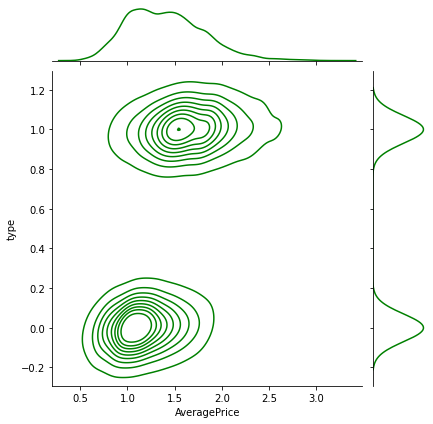

In [6]:

sns.jointplot('AveragePrice', 'type', data=df,
              kind="kde", color="g");

**Para la variable region la convertimos en númerica usando one-hot-encoding**

In [7]:
df = pd.get_dummies(df)
df



,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,month,day,region_Albany,region_Atlanta,region_BaltimoreWashington,region_Boise,region_Boston,region_BuffaloRochester,region_California,region_Charlotte,region_Chicago,region_CincinnatiDayton,region_Columbus,region_DallasFtWorth,region_Denver,region_Detroit,region_GrandRapids,region_GreatLakes,region_HarrisburgScranton,region_HartfordSpringfield,region_Houston,region_Indianapolis,region_Jacksonville,region_LasVegas,region_LosAngeles,region_Louisville,region_MiamiFtLauderdale,region_Midsouth,region_Nashville,region_NewOrleansMobile,region_NewYork,region_Northeast,region_NorthernNewEngland,region_Orlando,region_Philadelphia,region_PhoenixTucson,region_Pittsburgh,region_Plains,region_Portland,region_RaleighGreensboro,region_RichmondNorfolk,region_Roanoke,region_Sacramento,region_SanDiego,region_SanFrancisco,region_Seattle,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,0,2015,12,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,0,2015,12,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,0,2015,12,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,0,2015,12,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,0,2015,11,29,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,1,2018,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
18245,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,1,2018,1,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
18246,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,1,2018,1,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
18247,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,1,2018,1,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# 2 Visualización de datos


## 2.1 Histogramas
Se observa que la mayoria de caracteristicas presenta una distribuccion uniforme, excepto para la variable del mes

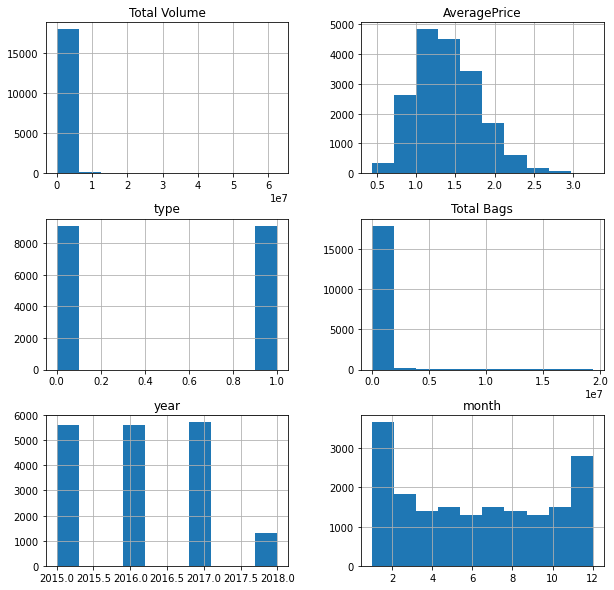

In [8]:
features = ['Total Volume', 'AveragePrice', 'type', 'Total Bags', 'year', 'month']
df[features].hist(figsize=(10, 10));

## 2.2 Gráficos de densidad

Con estos diagramas podemos observar de forma más suavizada la distribución de datos de cada una de las características donde se puede observar de forma más clara

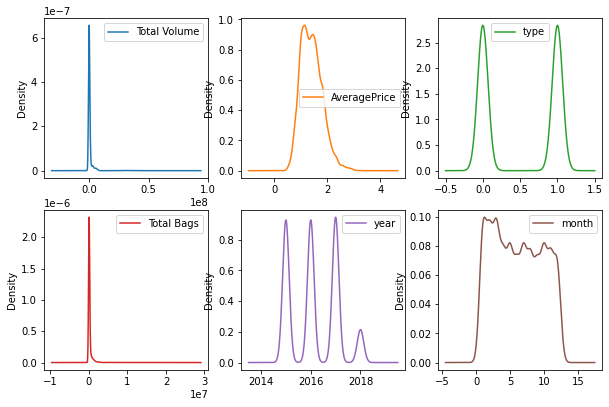

In [9]:
df[features].plot(kind='density', subplots=True, layout=(3, 3), 
                  sharex=False, figsize=(10, 10));

## 2.3 Grafico de correlacion - mapa de calor
Se observa que la correlacion fuerte entre total volumen y el total de canastos como es de esperarse, y también para interes las variables del tipo de aguacate frente al precio promedio 

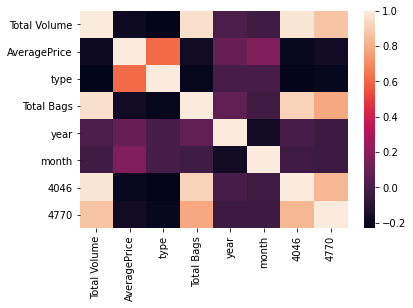

In [10]:

features = ['Total Volume', 'AveragePrice', 'type', 'Total Bags', 'year', 'month', '4046','4770']
corr_matrix = df[features].corr()
sns.heatmap(corr_matrix);

**Scatterplot matrix**
Observamos la matriz de diagramas de disperción, donde la diagonal contiene las distruciones de las variables correspondientes, y los diagramas de disperción para cada par de variables. Observamos que existe una fuerte correlación positiva entre el total Bags y small Bags y en otras una debil correlación positiva como es el caso de total bags y large bags.

Se quitan las variables de las ciudades para agilizar el proceso de la visualizacion

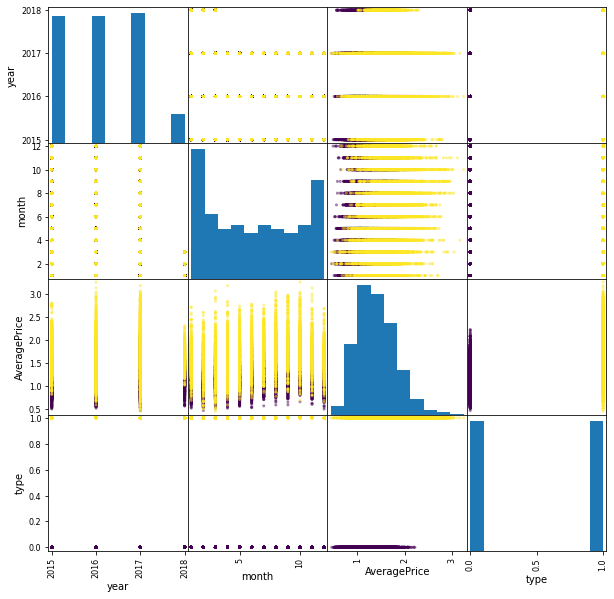

In [11]:
pd.plotting.scatter_matrix(df[['year', 'month', 'AveragePrice', 'type']],c=df['type'].values, figsize=(10, 10));

# 3  Cargamos la clase "type" en un arreglo aparte y la eliminamos del DataFrame 

In [12]:
X = df.drop(columns=['type'], axis=1).values
y = df['type'].values

print(X.shape)
print(y.shape)


(18249, 66)
(18249,)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


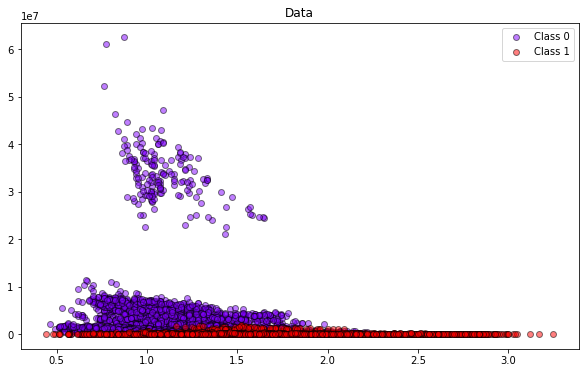

In [13]:
pl.figure(figsize = (10, 6))    
plot_data(X, y)

# 4 Creamos la partición de entrenamiento y prueba
Particionamos los datos en 30% para pruebas y 70% de los datos para realizar el entrenamiento

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)



# **MODELO RANDOM FOREST**
#5 Optimización aleatoria de parametros
Scikit-Learn permite hacer también una exploración aleatoria de los parámetros, la cual se ha demostrado empiricamente que es más eficiente que optimizar los parámetros usando una malla con GridSearchCV.
Utilizamos 5 pliegues cv = 5 para la optimiación aleatoria con 20 iteraciones

In [26]:
clf = RandomForestClassifier()

param_dist = {"n_estimators": randint(4, 800),
              "max_features": uniform()}

n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, 
                                   n_jobs=-1, verbose=2)

In [31]:
start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV tomó {} segundos usando {} configuraciones".format(time() - start,
                                                                               n_iter_search))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.6min finished


RandomizedSearchCV tomó 1138.275175333023 segundos usando 20 configuraciones


Extraemos los datos con mejor desempeño promedio

In [17]:
cv_results = pd.DataFrame(random_search.cv_results_)

cv_results = cv_results[['param_n_estimators', 'param_max_features', 'mean_test_score']]
cv_results.sort_values(by='mean_test_score', ascending=False).head()

,param_n_estimators,param_max_features,mean_test_score
9,271,0.0885104,0.998826
12,627,0.227797,0.998591
17,484,0.198302,0.998513
2,397,0.323276,0.998513
4,797,0.222165,0.998513


Observamos la mejor configuración y su puntaje sobre todas las particiones de validación:

In [18]:
random_search.best_params_

{'max_features': 0.08851039289085838, 'n_estimators': 271}

In [19]:
random_search.best_score_

0.998825739755144

# 6 Matrix de confusión

In [20]:
y_pred = random_search.best_estimator_.predict(X_test)

print (confusion_matrix(y_test, y_pred))

[[2737    1]
 [   1 2736]]


##Interpretación## 
De 2738 ejemplos que eran de aguacate tipo convencional el modelo predijo bien 2737 ejemplos bien, y solo 1 ejemplo lo clasifico erroneamente.
De 2736 ejemplos que eran de aguacate tipo organico el modelo predijo bien 2736 ejemplos bien, y solo 1 ejemplo lo clasifico erroneamente.



In [21]:
random_search.score(X_test, y_test)

0.9996347031963471

In [30]:
from sklearn import metrics

print('Precision: {}'.format(metrics.precision_score(y_test, y_pred)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred)))
print('F_1 score: {}'.format(metrics.f1_score(y_test, y_pred)))

Precision: 0.999634636463281
Recall: 0.999634636463281
F_1 score: 0.999634636463281
